# Connect to Drive

In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np

# date data process
from datetime import date, timedelta, datetime

# text processing
import nltk
from nltk.corpus import stopwords

# plot
%matplotlib inline
import matplotlib.pyplot as plt

# sorting dict data
import heapq

# for statistics
import statsmodels.api as sm
from statsmodels.robust.scale import mad
from scipy.stats import t as student_t
import math

# Stopwords Setup

In [3]:
# download and get the stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# optional to add more custom_stopwords
custom_stopwords = ["NaN"]
stop_words.update(custom_stopwords)

# Read Data

In [6]:
# start date and end date of the datasets
start_dt = date(2020, 3, 22)
end_dt = date(2020, 8, 22)

# store daily count for each token
daily_single_token_count = {}

# store the highest count of each token from 2020.3.22 ~ 2020.8.22
token_highest_count = {}

# daily min count
daily_min_token_count = {}

# read data
dt = start_dt
while dt <= end_dt:
    file_path = f'/content/drive/MyDrive/../dataset/{dt.isoformat()}/{dt.isoformat()}_top1000terms.csv'

    df = pd.read_csv(file_path, names=['token', 'count'])
    df['token'] = df['token'].astype(str)
    df['count'] = df['count'].astype(int)

    # filter for eligible tokens
    df['token'] = df['token'].apply(lambda token: token if len(token) >= 3 else "N/A")
    df['token'] = df['token'].apply(lambda token: token if token.isalnum() and not token.isdigit() else "N/A")
    df['token'] = df['token'].apply(lambda token: token if token not in stop_words else "N/A")
    df = df[df['token'] != "N/A"]

    df_str = dt.isoformat()

    # initialize the date key in the dictionary
    daily_single_token_count[df_str] = {}

    for index, row in df.iterrows():
        token = row['token']
        count = row['count']

        # store count of a token in a specific day
        daily_single_token_count[df_str][token] = count

        # update the highest count of this specific token from 2020.3.22 ~ 2020.8.22
        # check if the token is already in the dictionary
        if token not in token_highest_count:
            # if not, add it with the current count
            token_highest_count[token] = count
        else:
            # if it is, update the count if the current count is higher
            if token_highest_count[token] < count:
                token_highest_count[token] = count

    # store the min count of tokens in this specific day
    daily_min_token_count[df_str] = df['count'].min()

    # go to the next day
    dt += timedelta(days=1)

# Exploratory Data Analysis

In [63]:
# top 10 spike
top_10_terms = heapq.nlargest(10, token_highest_count.items(), key=lambda item: item[1])
top_10_terms

[('coronavirus', 365236),
 ('covid', 255660),
 ('covid19', 248841),
 ('nan', 88223),
 ('trump', 75936),
 ('cases', 60019),
 ('people', 54861),
 ('amp', 54157),
 ('new', 47389),
 ('vaccine', 47077)]

In [64]:
# eligible tokens
print(f'Number of eligible tokens: {len(token_highest_count)}')

Number of eligible tokens: 4115


In [10]:
# We are only interested in top 1000 spikes from 2020.3.22 ~ 2020.8.22
selected_tokens = heapq.nlargest(1000, token_highest_count, key=token_highest_count.get)
selected_tokens[:15]

['coronavirus',
 'covid',
 'covid19',
 'nan',
 'trump',
 'cases',
 'people',
 'amp',
 'new',
 'vaccine',
 'via',
 'pandemic',
 'polmascegahcovid19',
 'siagalawancovid19',
 'bolsonaro']

# Construct Time Series

In [11]:
# store tokenwise time series
timeseries = {}
# store dates
timeseries_index =[]

In [13]:
# initialize timeseries and timeseries_index
timeseries = {token: [] for token in selected_tokens}
timeseries_index = []

dt = start_dt

while dt <= end_dt:
    dt_str = dt.isoformat()
    timeseries_index.append(dt_str)

    for token in selected_tokens:
        # construct the timeseries using `daily_single_token_count`
        # If a token does not have count for that date,
        # use that day's minimum count
        try:
            count = daily_single_token_count[dt_str][token]
        except KeyError:
            count = daily_min_token_count.get(dt_str, 0)
        timeseries[token].append(count)

    dt += timedelta(days=1)

In [14]:
# check time series index structure
print(timeseries_index[:10])
print(len(timeseries_index))

['2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']
154


In [15]:
# check time series for 'school' token
timeseries['school'][:10]

[1338, 2029, 1801, 1599, 2279, 2188, 1689, 2124, 2584, 2516]

# Time Series Visualization

In [70]:
def token_trend(token_name):
    # create a dataframe
    df = pd.DataFrame({'Date': timeseries_index, 'Value': timeseries[token_name]})
    df['Date'] = pd.to_datetime(df['Date'])

    # create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Value'], label='Value', linewidth=2)

    # add title and labels
    plt.title(f'Line Chart of "{token_name}" Token Count over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')

    # format the x-axis for better readability
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate(rotation=45)

    # add a legend
    plt.legend()

    # show the plot
    plt.show()


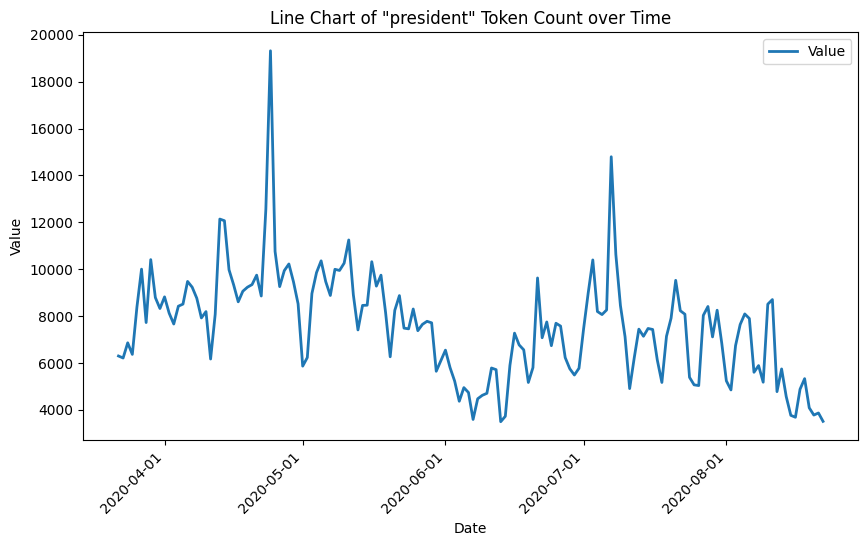

In [71]:
token_trend('president')

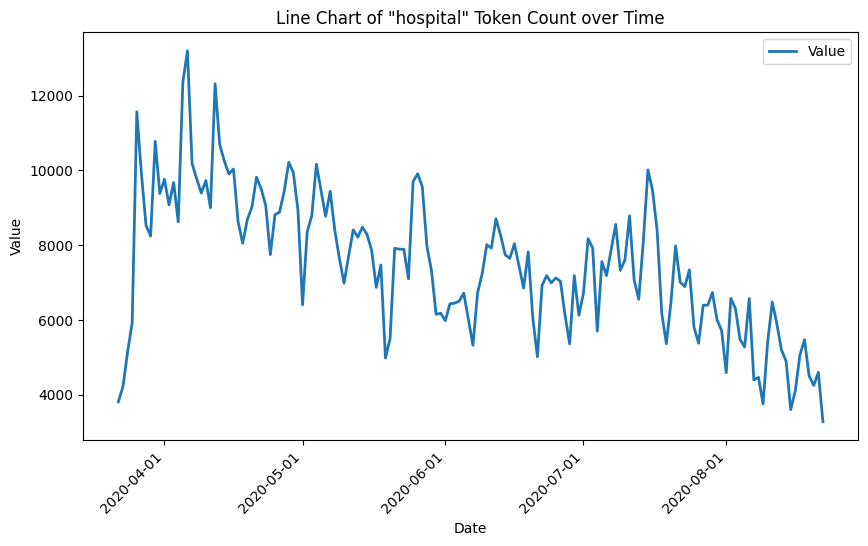

In [72]:
token_trend('hospital')

# Seasonal Trend Decomposition using Loess

In [21]:
# seasonal and trend decomposition using Loess for time series
def stl(series: np.ndarray, period: int):

    decomp = sm.tsa.seasonal_decompose(series, period=period)

    return decomp.seasonal, decomp.trend, decomp.resid

In [77]:
def token_trend_decomposition(token_name):
    # perform STL decomposition
    seasonal, trend, residual = stl(np.array(timeseries[token_name]), period=7)

    # create a DataFrame for plotting
    df = pd.DataFrame({
        'Date': pd.to_datetime(timeseries_index),
        'Seasonal': seasonal,
        'Trend': trend,
        'Residual': residual
    })

    # create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

    # plot seasonal component
    ax1.plot(df['Date'], df['Seasonal'], label='Seasonal', color='blue')
    ax1.set_title('Seasonal')

    # plot trend component
    ax2.plot(df['Date'], df['Trend'], label='Trend', color='orange')
    ax2.set_title('Trend')

    # plot residual component
    ax3.plot(df['Date'], df['Residual'], label='Residual', color='green')
    ax3.set_title('Residual')
    ax3.set_xlabel('Date')

    # update layout
    fig.suptitle(f'STL Decomposition of "{token_name}" Token Time Series', fontsize=16)
    fig.tight_layout(pad=3.0)

    # rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # show the plot
    plt.show()

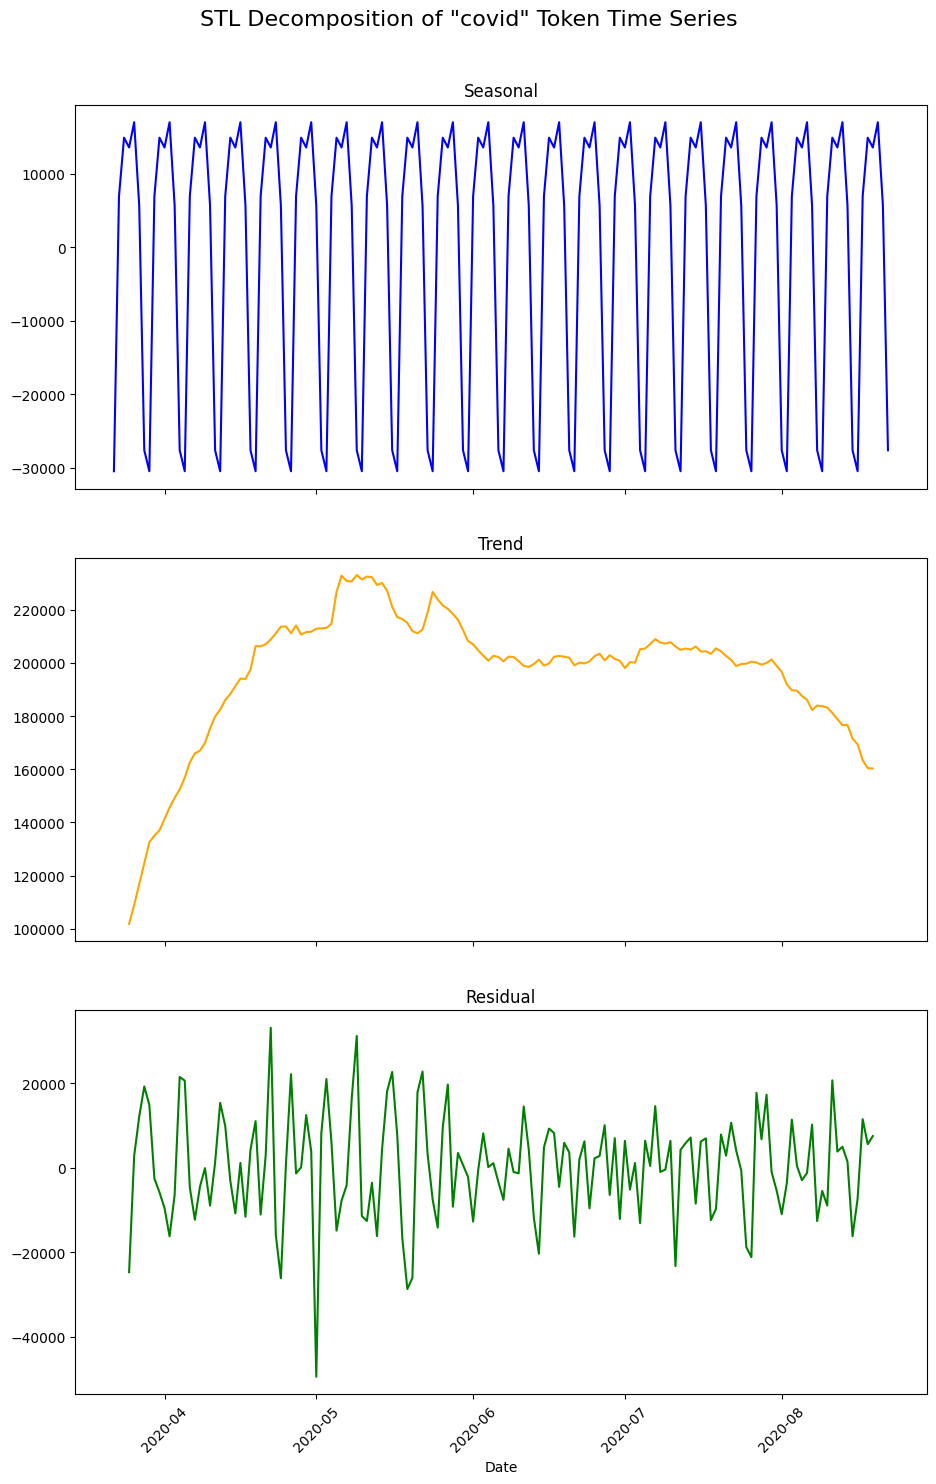

In [78]:
token_trend_decomposition("covid")

# Construct Robust S-H-ESD (Seasonal Hybrid Extreme Studentized Deviate) Algorithm

#### Test statistics
In Robust ESD test, I first define the maximum number of anomalies $K$, and then compute the following test statistic for the $k=1,2,...,K$ most extreme values in the data set:

$$
C_k=\frac{\max_k |x_k-\tilde{x}|}{\hat{\sigma}}
$$

where $\tilde{x}$ is the median of the series and $\hat{\sigma}$ is the median absolute deviation (MAD), which is defined as $\text{MAD} = \text{median}(|X-\text{median}(X)|)$.

#### Critical value
The test statistic is then used to compare with a critical value, which is computed using following equation:

$$
\lambda_k=\frac{(n-k) t_{p,\ n-k-1}}{\sqrt{(n-k-1+t_{p,\ n-k-1}^2)(n-k+1)}}
$$

To compute the $t_{p,\ n-k-1}$ in critical value, I used the following code

```python
from scipy.stats import t as student_t
p = 1 - alpha / (2 * (N - k + 1))
t = student_t.ppf(p, N - k - 1)
```
#### Anomaly direction
The another thing I did was to determine the direction or the anomaly (i.e., the anomaly is going up or going down). This information is useful because in some anomaly detection task such as detecting error counts, people only care when anomaly increase a lot

To determine the direction of anomaly, I used the sign of the $|x_k-\tilde{x}|$ in $C_k$. If sign is positive, then the anomaly is greater than median and it's very likely to be a spike, otherwise, it should be a dip.

In [28]:
def robust_seasonal_ESD_test(ts, max_anomalies=5, seasonal=False, period=None, alpha=0.05, threshold=1.0):

  # copy the time series
  series = np.copy(ts)

  # implement the seasonal decomposition as an option
  if seasonal:
      if not period:
          raise RuntimeError("Period must be set if the time series is seasonal")
        # remove the seasonal signal and median (based on the paper)
      series = series - stl(ts, period=7)[0] - np.median(series)

  # n stores the original length of the series for calcaulting statistics
  N = len(series)

  # tx_index is used to keep track of the deletion of anomaly index
  ts_index = np.array(range(N))

  # store the information for the anomalies
  anomalies_list = []

  # n_anomalies is used to keep track of the number of detected anomalies
  n_anomalies = 0

  # date_index
  date_index = timeseries_index.copy()


  for k in range(1, max_anomalies + 1):

    # compute the test statistic C_k
    C_k = max(abs(series-np.median(series)))/mad(series)

    # determine the direction or anomaly
    direction = ("positive" if max(abs(series-np.median(series))) in series-np.median(series) else "negative")

    # compute the critical value lambda_k
    p = 1 - alpha / (2 * (N - k + 1))
    t = student_t.ppf(p, N - k - 1)
    lambda_k = (N - k) * t / ((N - k - 1+ t**2)*(N - k +1))**0.5

    # if Ck > lambdak, then the most extreme value in this round can be detected as anomaly
    score = C_k / lambda_k
    # threshold is normally set to 1; >threshold means C_k > lambda_k
    if score > threshold:
      # update the eligible number of anomalies
      n_anomalies = 0
    #   # if C_k < lambda_k, stop the iteration for detecting the next possible anomaly
    else:
      break

    # find the index of the most extreme value in this round
    max_idx = np.argmax(abs(series-np.median(series)))

    # store the information for this anomaly
    anomalies_list.append({
                  "rank": k, # the rank of the extreme level
                  "index": int(ts_index[max_idx]), # index of the extreme value
                  "date": date_index[ts_index[max_idx]], # date of the extreme value
                  "value": float(ts[ts_index[max_idx]]), #
                  "direction": direction,
                  "score": round(score, 2)
              })

    # remove the identified value from both time-series and index
    series = np.delete(series, max_idx)
    ts_index = np.delete(ts_index, max_idx)
  return anomalies_list

# Anomaly Visualization and Validation

In [55]:
def plot_anomalies(token_name):

  anomalies_list = robust_seasonal_ESD_test(timeseries[token_name], max_anomalies=5, seasonal=True, period=7, alpha=0.05, threshold=1)

  # only keep anomalies going up
  anomaly_index = []
  anomaly_value = []

  for i in anomalies_list:
    if i['direction'] == 'positive':
      anomaly_index.append(i['index'])
      anomaly_value.append(i['value'])

  anomaly_date = [timeseries_index[i] for i in anomaly_index]

  date_range = pd.date_range(start='2020-03-22', end='2020-08-22')

  ts = np.array(timeseries[token_name])

  fig, ax = plt.subplots()
  ax.plot(date_range, ts)

  # Format the x-axis to show dates properly
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))

  plt.scatter(date_range[anomaly_index], anomaly_value, s=50.0, c='red')

  # Annotate the anomalies with the corresponding dates
  for idx, val, date in zip(anomaly_index, anomaly_value, anomaly_date):
    plt.annotate(date_range[idx].strftime('%Y-%m-%d'), (date_range[idx], val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')

  plt.grid()
  plt.xlabel('Date')
  plt.ylabel('# of appearance')
  plt.xticks(rotation=45)
  plt.show()

## Visualization for 'djokovic'

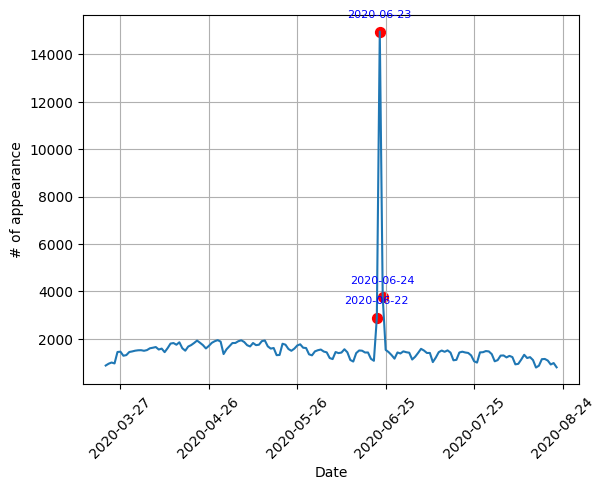

In [58]:
plot_anomalies('djokovic')

## Validation for 'djokovic'

https://www.nytimes.com/2020/06/23/sports/tennis/novak-djokovic-coronavirus.html


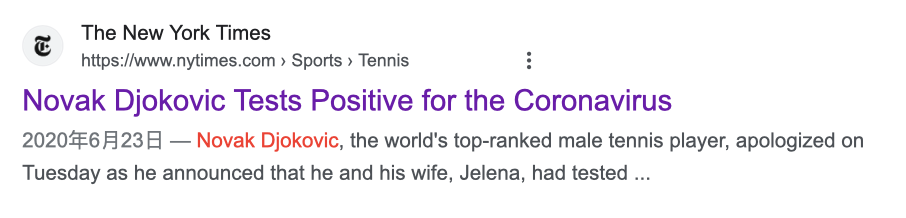

## Visualization for 'earthday2020'

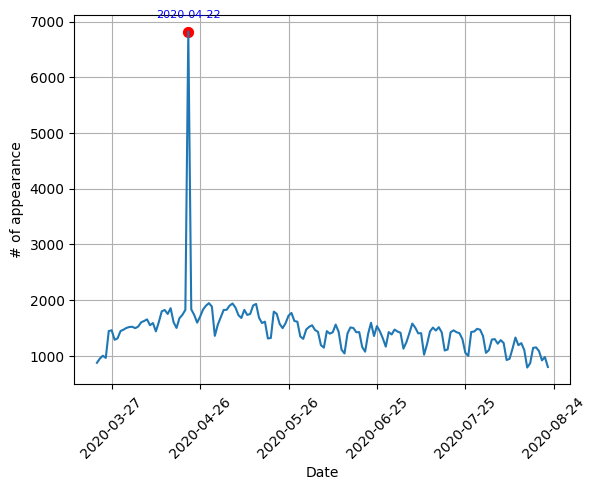

In [59]:
plot_anomalies('earthday2020')

## Validation for 'earthday2020'

https://www.earthday.org/earth-day-2020/

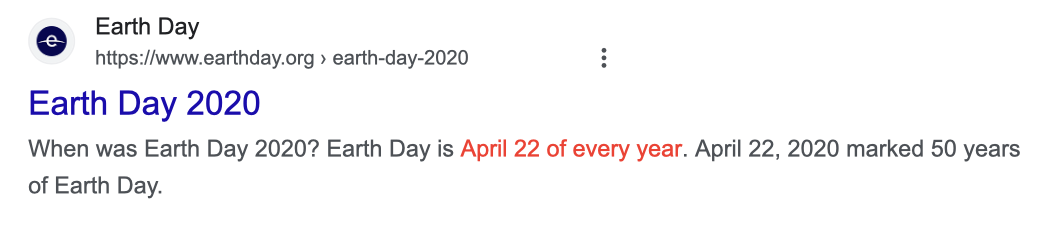

## Visualization for 'disinfectant'

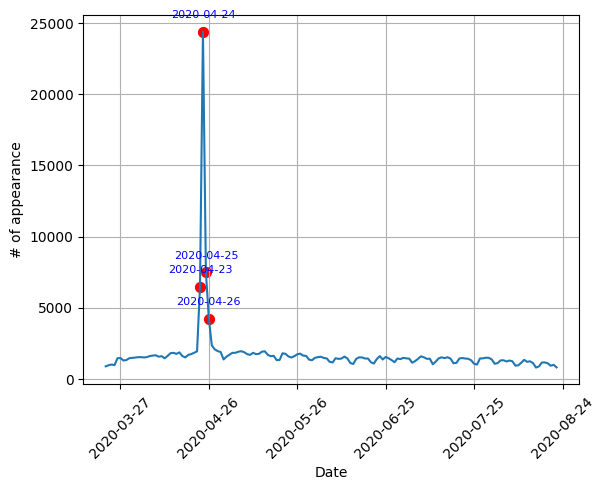

In [60]:
plot_anomalies('disinfectant')

## Validation for 'disinfectant'

https://www.nbcnews.com/politics/donald-trump/trump-suggests-injection-disinfectant-beat-coronavirus-clean-lungs-n1191216

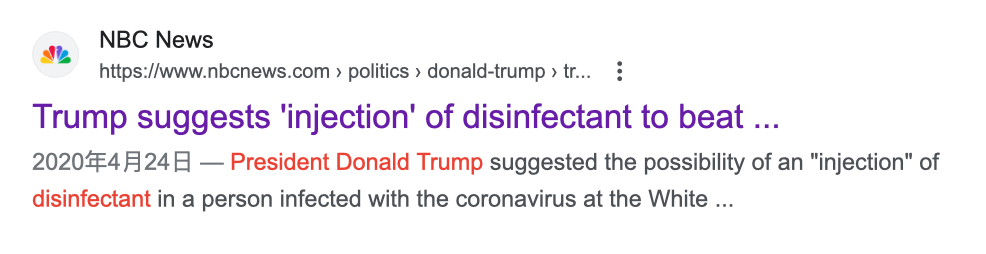

## Visualization for 'worldhealthday'

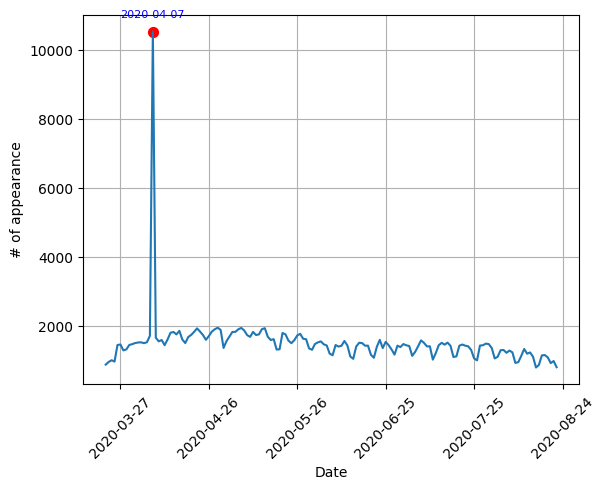

In [62]:
plot_anomalies('worldhealthday')

## Validation for 'worldhealthday'

https://www.paho.org/en/campaigns/world-health-day-2020

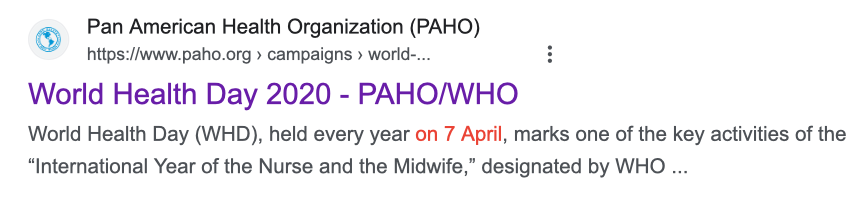

## Visualization for 'biden'

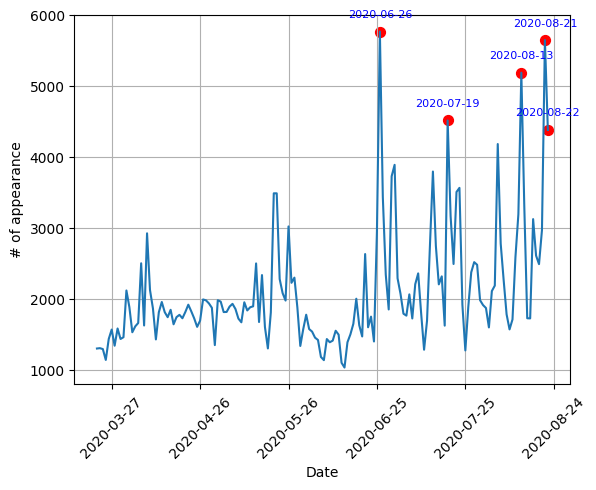

In [61]:
plot_anomalies('biden')

## Validation for 'biden'

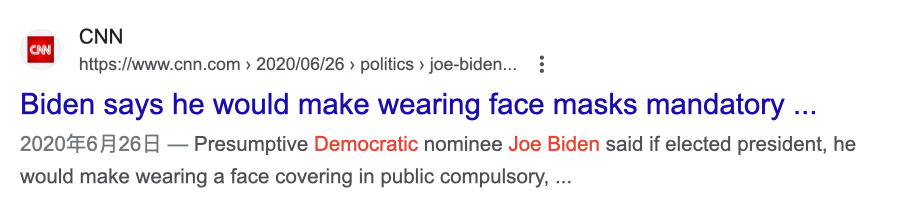

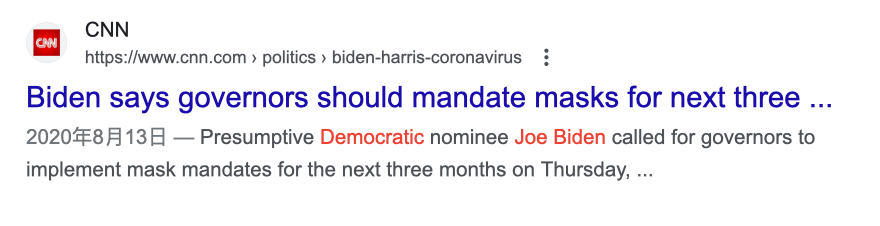

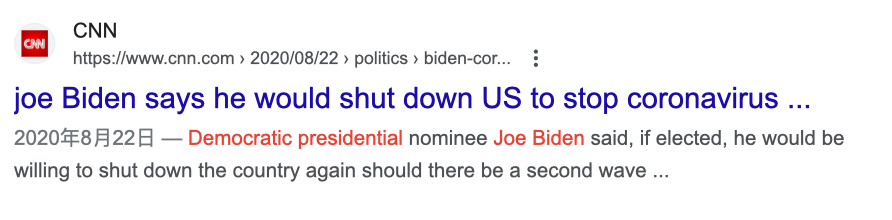